In [1]:
import numpy as np
from astropy import constants as ca
from funcs.blackbody_model import _brightness_mod, brightness_mod_continous
from funcs.probabilities_emcee import log_likelihood, log_prior_global_uniform, \
    log_probability, plot_corner_emcee, plot_walker_emcee, display_median_from_chain, \
    log_loglikelihood, log_logprior_global_uniform, log_logprobability
import sys 
import matplotlib.pyplot as plt
import astropy.units as u

In [2]:
#this is a good thing to play a little around with! 

In [2]:
#import brightness and error for each Flare and TRAPPIST-1
flare1 = np.genfromtxt("Test/results/values/brightness_flare_Test.txt",delimiter="," , skip_header=1)
#flare2 = np.genfromtxt("../results/values/brightnesstot_flare2_TRAPPIST-1.txt",delimiter="," , skip_header=1)
trappist = np.genfromtxt("Test/results/values/brightness_Test_withCCDeffeciency.txt", delimiter= ",", skip_header=1)
trappist_SED = np.genfromtxt("../data/TRAPPIST1_Semimodel_Wilson/TRAPPIST-1_model_const_res_v07.ecsv")
trappistflux_M2 = np.genfromtxt("../results/values/brightness_TRAPPIST-1_withCCDeffeciency.txt", delimiter= ",", skip_header=1)

In [3]:
#import flare brightness and spectral energy dist. in M2
wavelength_SED, flux_SED = trappist_SED[:,0]*1e-10, trappist_SED[:,1]
brightness_flares = np.reshape(flare1, (1,4))

brightnesserror_flares = np.reshape(flare1, (1,4)) * 0.25
#flux/brighntess is in erg cm-2 -s

#Import M2 response, passband limits
iters = ["g", "r", "i", "z"]
limit, wavelength_M2, response_M2 = [], [], []

for i in iters: 
    #limit are the limits of the passband in wavelength 
    limit.append(np.load("../data/MuSCAT2_response/MuSCAT2_limit_{}.npy".format(str(i))))
    wavelength_M2.append(np.load("../data/MuSCAT2_response/MuSCAT2_wavelength_{}.npy".format(str(i))))
    response_M2.append(np.load("../data/MuSCAT2_response/MuSCAT2_response_{}_bandpass.npy".format(str(i))))

In [5]:
#units of brightness flares? I think it should be in standart units SI

In [4]:
flux_SED = flux_SED * u.erg * u.s**(-1) *u.cm**(-2) * u.Angstrom**(-1)
flux_SED = flux_SED.to("W m^-3")
flux_SED = flux_SED.value

In [5]:
from scipy.optimize import minimize

#Define parameters of the TRAPPIST-1
parameters_op = []
t_star = 2648 #[K] #Wilson et al 2021
r_star = 0.1192 * ca.R_sun.value
dist_star = dist_TRAP = 3.835084e+17 #[m]

#initial values for MCMC
for i in range(len(brightness_flares)):
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([5000,0.1] + 0.01 * np.random.randn(2))
    soln = minimize(nll, initial, args=(wavelength_SED, brightness_flares[i], \
                                        brightnesserror_flares[i], limit, flux_SED, \
                                        t_star, r_star, dist_star))
    T_op, a_op = soln.x 
    
    #ensure Temperature is not to high
    if T_op > 25000 or T_op < 3000:
        T_op = 6000 
        
    #ensure fraction of area is not negative
    if a_op < 0:
        a_op = 1e-6
    
    parameters_op.append([T_op, a_op])

parameters_op = np.asarray(parameters_op)

In [6]:
parameters_op

array([[7.00000353e+03, 9.99998937e-02]])

In [7]:
import emcee
import corner
import matplotlib.pyplot as plt


n = 2500 #number of steps in the chain
ndim = 2 #dimensions of the model i.e. parameters in the model
nwalkers = 40 #number of walkers

samples_total, samplesflat_total = [],[] 

#Emcee Flare fitting
for i in range(len(brightness_flares)):
    sys.stdout.write("Flare #" + str(i+1))
    
    pos = parameters_op[i] + 1e-8 * np.random.randn(nwalkers, ndim)
    
    
    
    #sampler
    sampler = emcee.EnsembleSampler(
                nwalkers, ndim, log_probability, args=(wavelength_SED, brightness_flares[i],\
                                                       brightnesserror_flares[i], limit, flux_SED, \
                                                       t_star, r_star, dist_star, log_prior_global_uniform))
    sampler.run_mcmc(pos, n, progress=True, )
    
    #flattensamples and discard burn in phase
    samplesflat_total.append(sampler.get_chain(discard=500, thin=15, flat=True))
    samples_total.append(sampler.get_chain())
    

  0%|▏                                        | 10/2500 [00:00<00:26, 94.77it/s]

Flare #1

100%|███████████████████████████████████████| 2500/2500 [00:26<00:00, 92.74it/s]


In [8]:
#Write chain data to arrays 

np.save("../data/MCMC/test_modelrecovery_samples_total", samples_total, allow_pickle=True, fix_imports=True)
np.save("../data/MCMC/test_modelrecovery_samplesflat_total", samplesflat_total, allow_pickle=True, fix_imports=True)

In [9]:
#log parameter space

import emcee
import corner
import matplotlib.pyplot as plt


n = 3000 #number of steps in the chain
ndim = 2 #dimensions of the model i.e. parameters in the model
nwalkers = 40 #number of walkers

samples_total, samplesflat_total = [],[] 

#Emcee Flare fitting
for i in range(len(brightness_flares)):
    sys.stdout.write("Flare #" + str(i+1))
    
    pos = np.log10(parameters_op[i] + 1e-8 * np.random.randn(nwalkers, ndim))
    
    
    
    #sampler
    sampler = emcee.EnsembleSampler(
                nwalkers, ndim, log_logprobability, args=(wavelength_SED, brightness_flares[i],\
                                                       brightnesserror_flares[i], limit, flux_SED, \
                                                       t_star, r_star, dist_star, log_logprior_global_uniform))
    sampler.run_mcmc(pos, n, progress=True, )
    
    #flattensamples and discard burn in phase
    samplesflat_total.append(sampler.get_chain(discard=500, thin=15, flat=True))
    samples_total.append(sampler.get_chain())
    

  0%|▏                                         | 9/3000 [00:00<00:33, 89.69it/s]

Flare #1

100%|███████████████████████████████████████| 3000/3000 [00:32<00:00, 93.69it/s]


In [10]:
#Write chain data to arrays 

np.save("../data/MCMC/test_modelrecovery_logsamples_total", samples_total, allow_pickle=True, fix_imports=True)
np.save("../data/MCMC/test_modelrecovery_logsamplesflat_total", samplesflat_total, allow_pickle=True, fix_imports=True)

In [10]:
#Load data from chain 

samples_total = np.load("../data/MCMC/test_modelrecovery_samples_total.npy")
samplesflat_total = np.load("../data/MCMC/test_modelrecovery_samplesflat_total.npy")

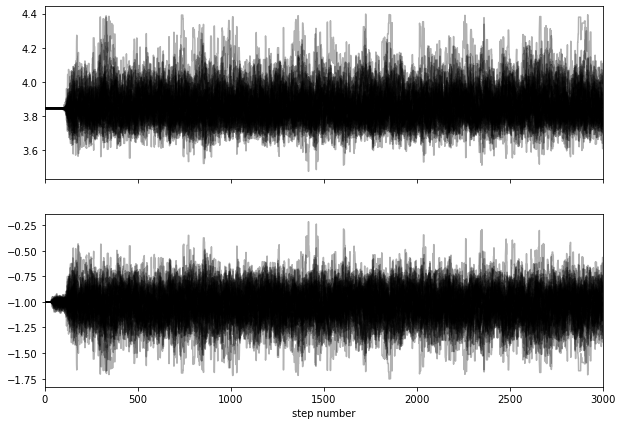

In [11]:
%matplotlib inline
plot_walker_emcee(samples_total)

In [12]:
def plot_corner_emcee(samples_flat, bins = 100, labels = ["log(T/K)","log(a)"]):
    
    for j in range(len(samples_flat)):
        fig = corner.corner(
        samples_flat[j], labels=labels, bins = bins
        );
    return 

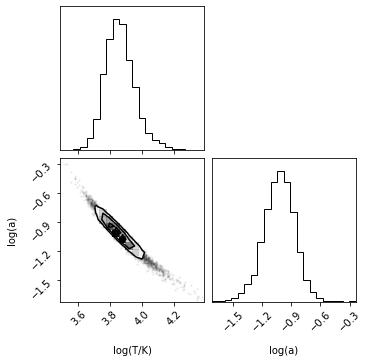

In [13]:
plot_corner_emcee(samplesflat_total, bins=22)

In [16]:
10**np.asanyarray(display_median_from_chain(samplesflat_total))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

/home/aaronmaas/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


array([[7165.989388337687],
       [array([1.21545596, 1.24714197])],
       [0.09536998897659806],
       [array([1.43722775, 1.40127321])]], dtype=object)

In [ ]:
## That is consitent with the input of T = 7000 K and a = 1e-1 